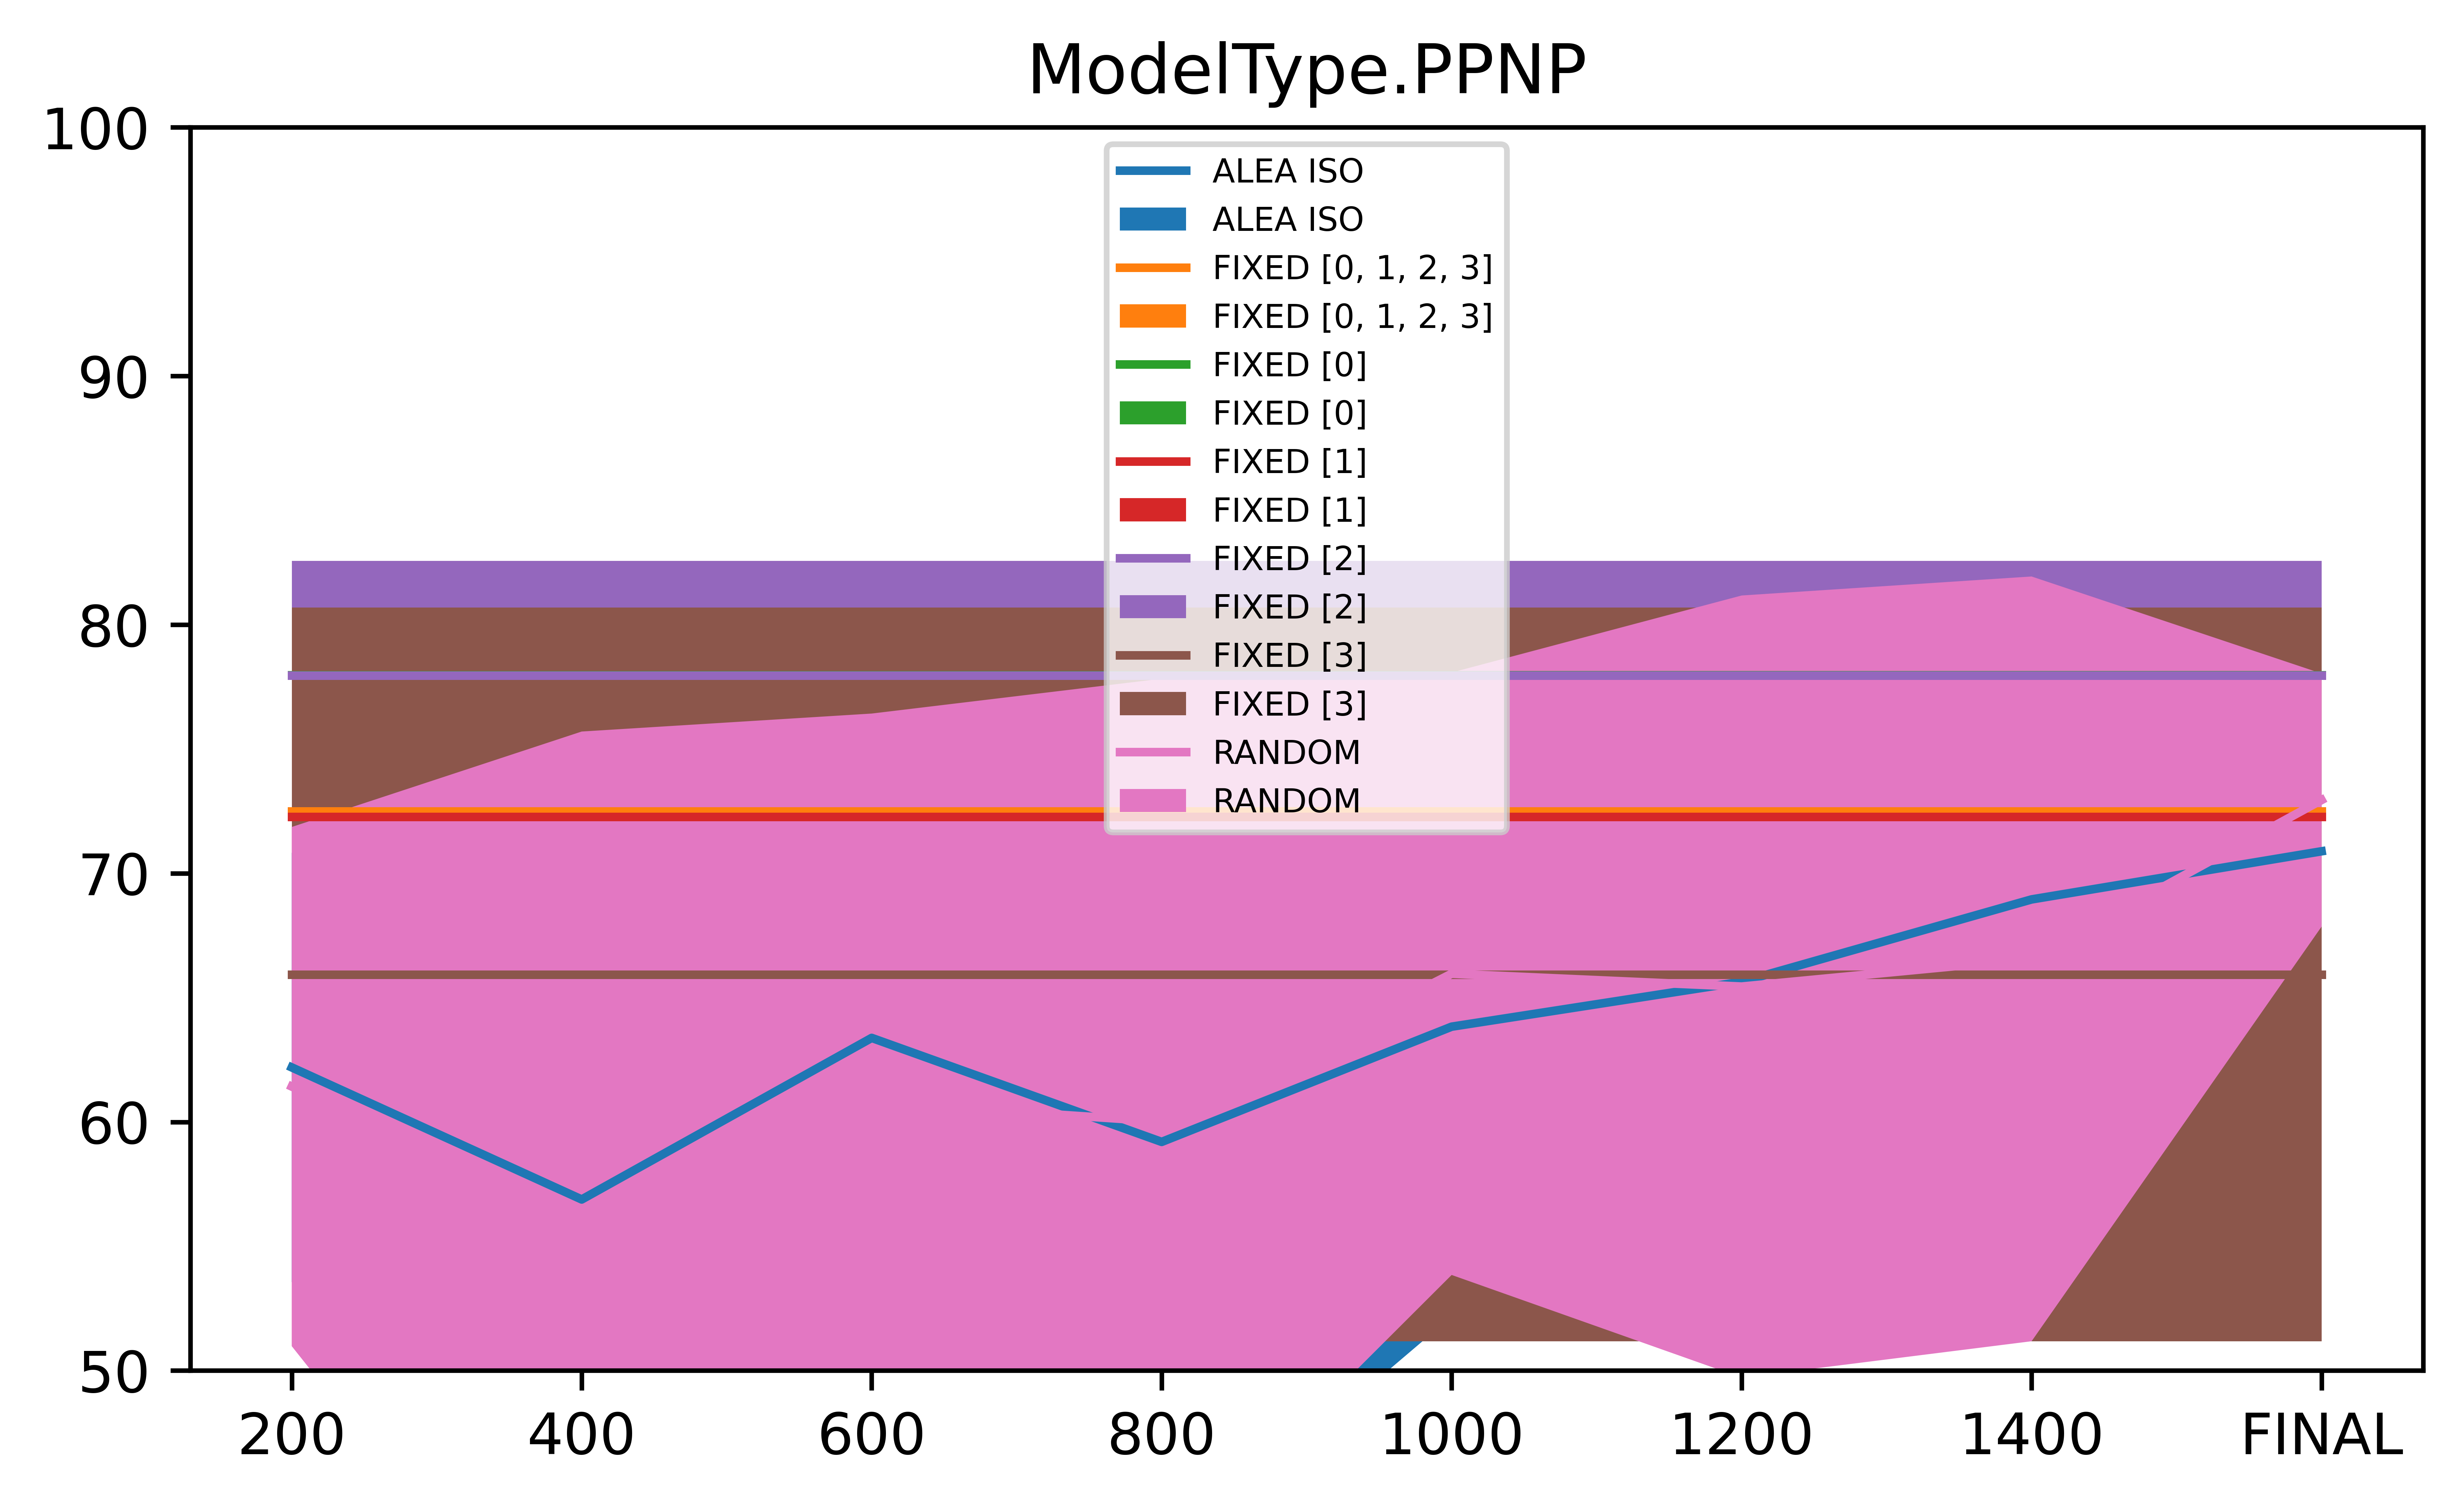

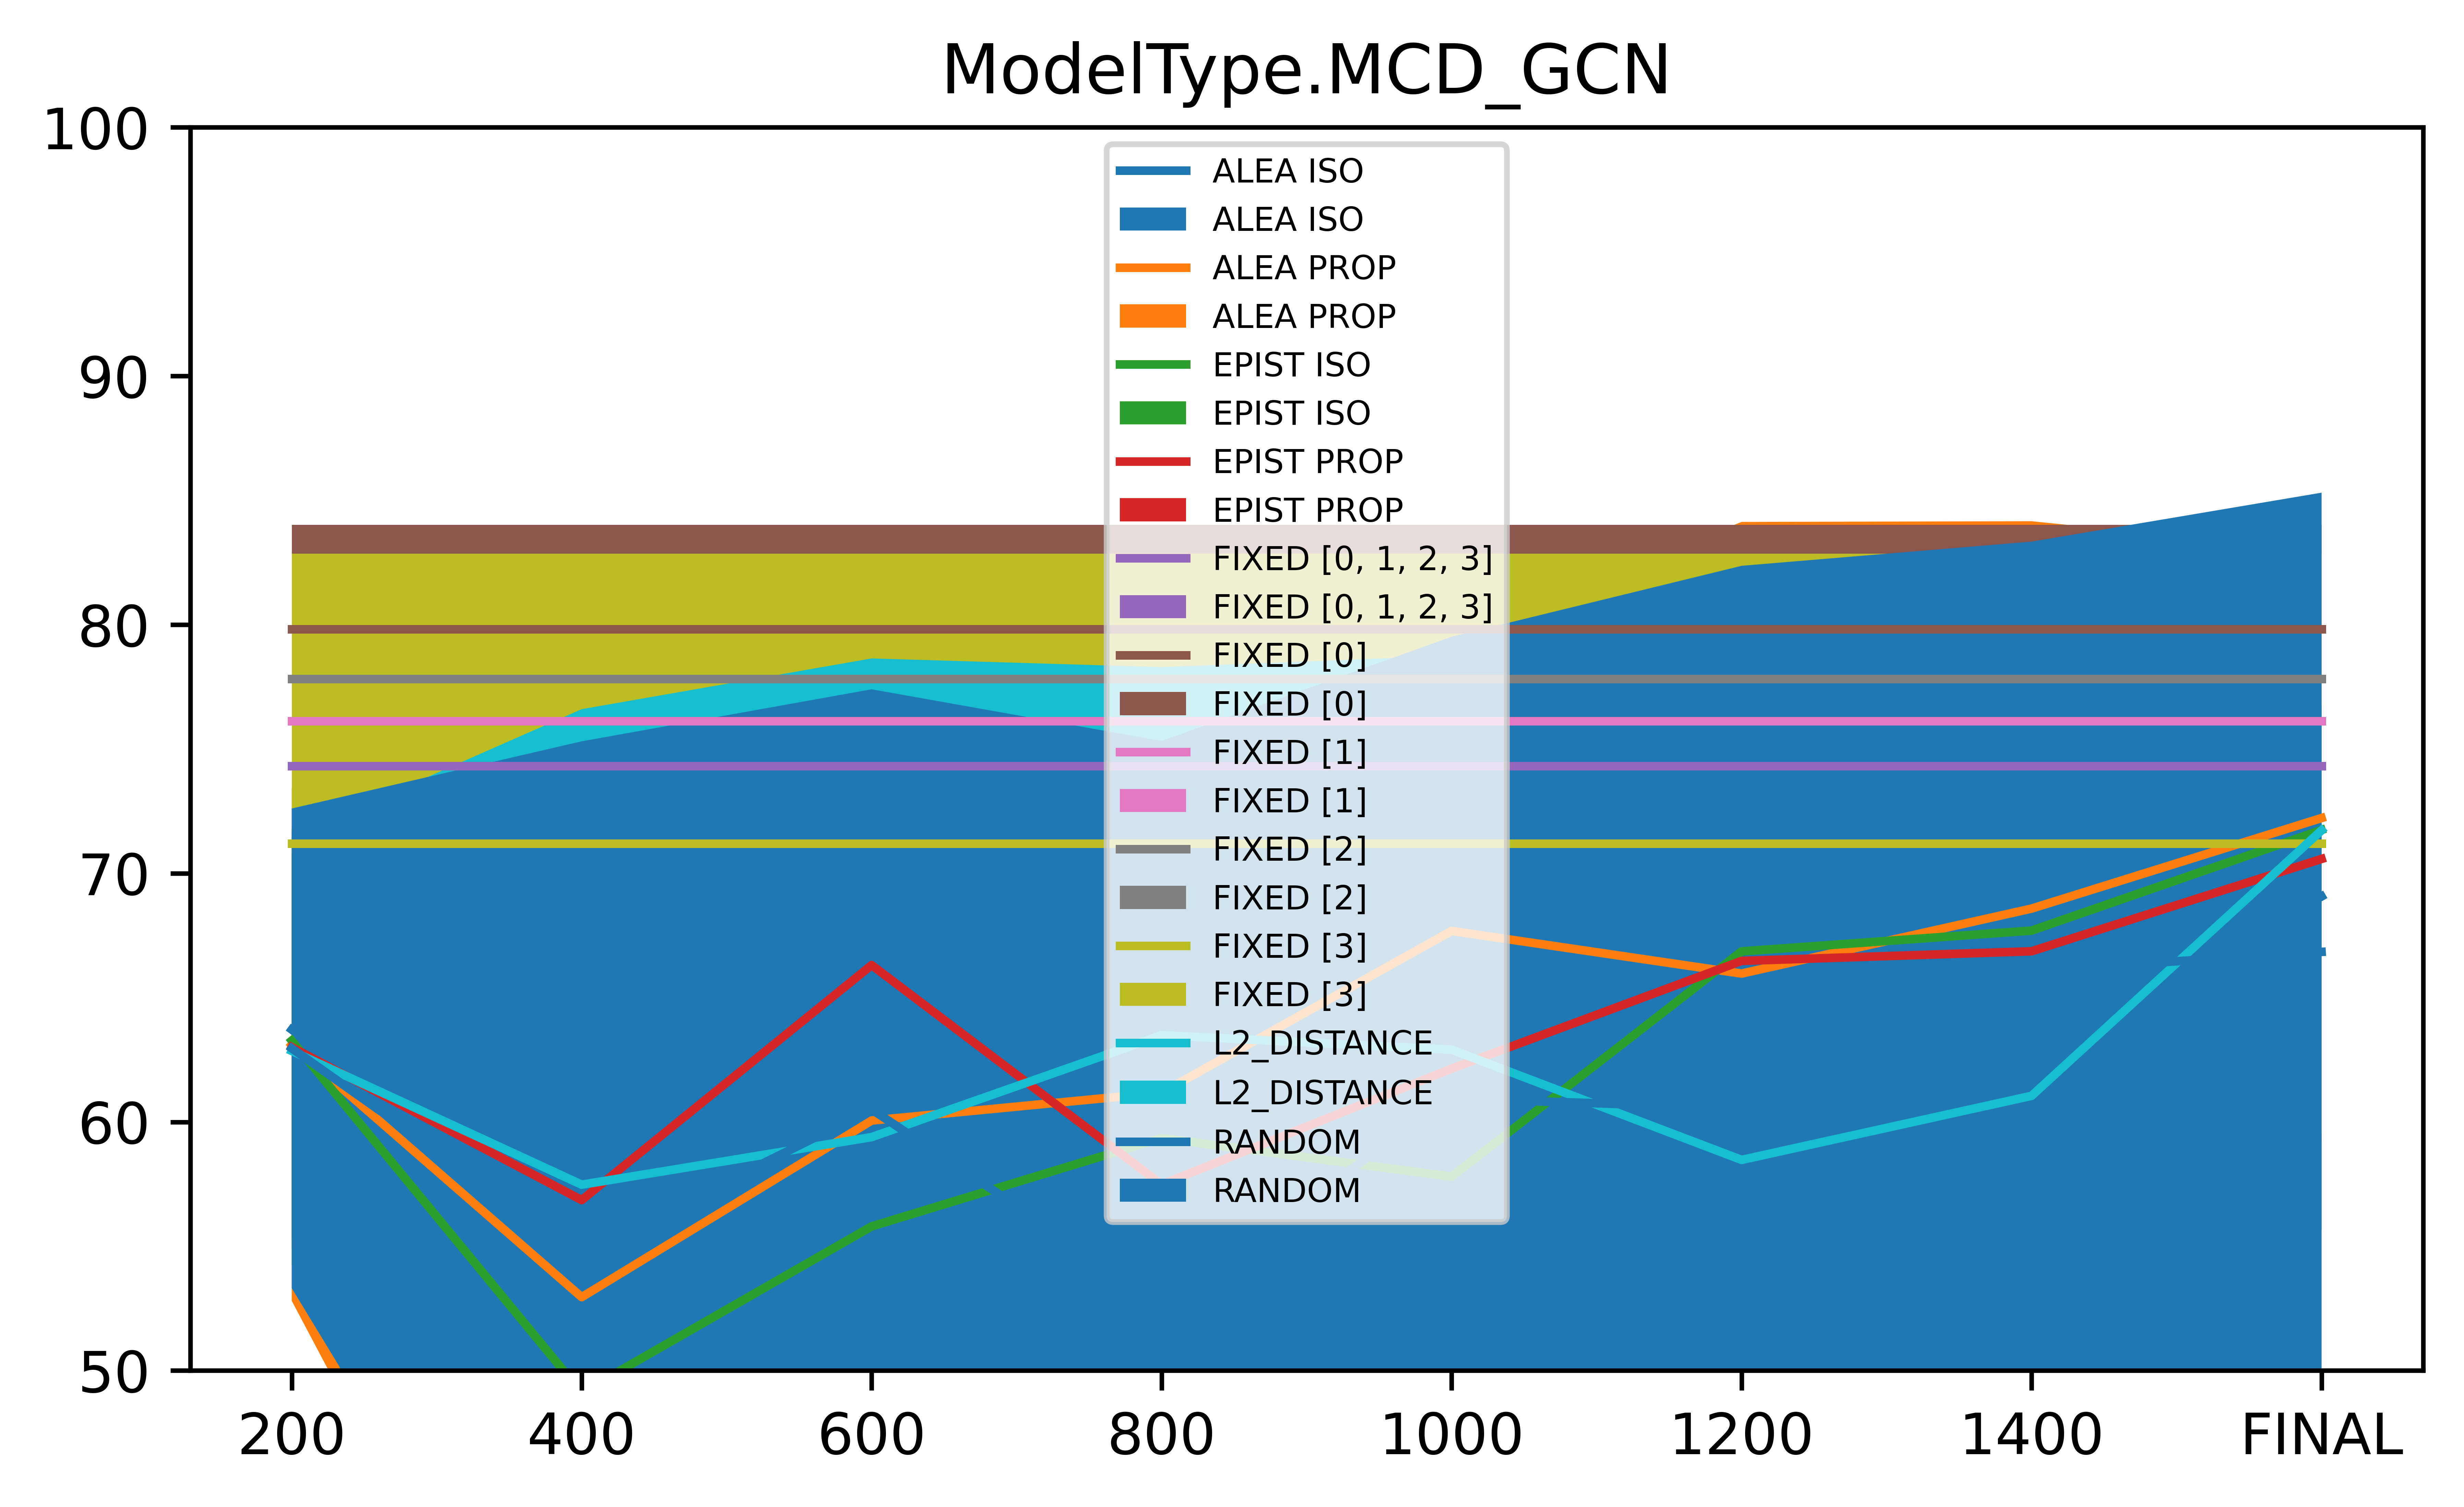

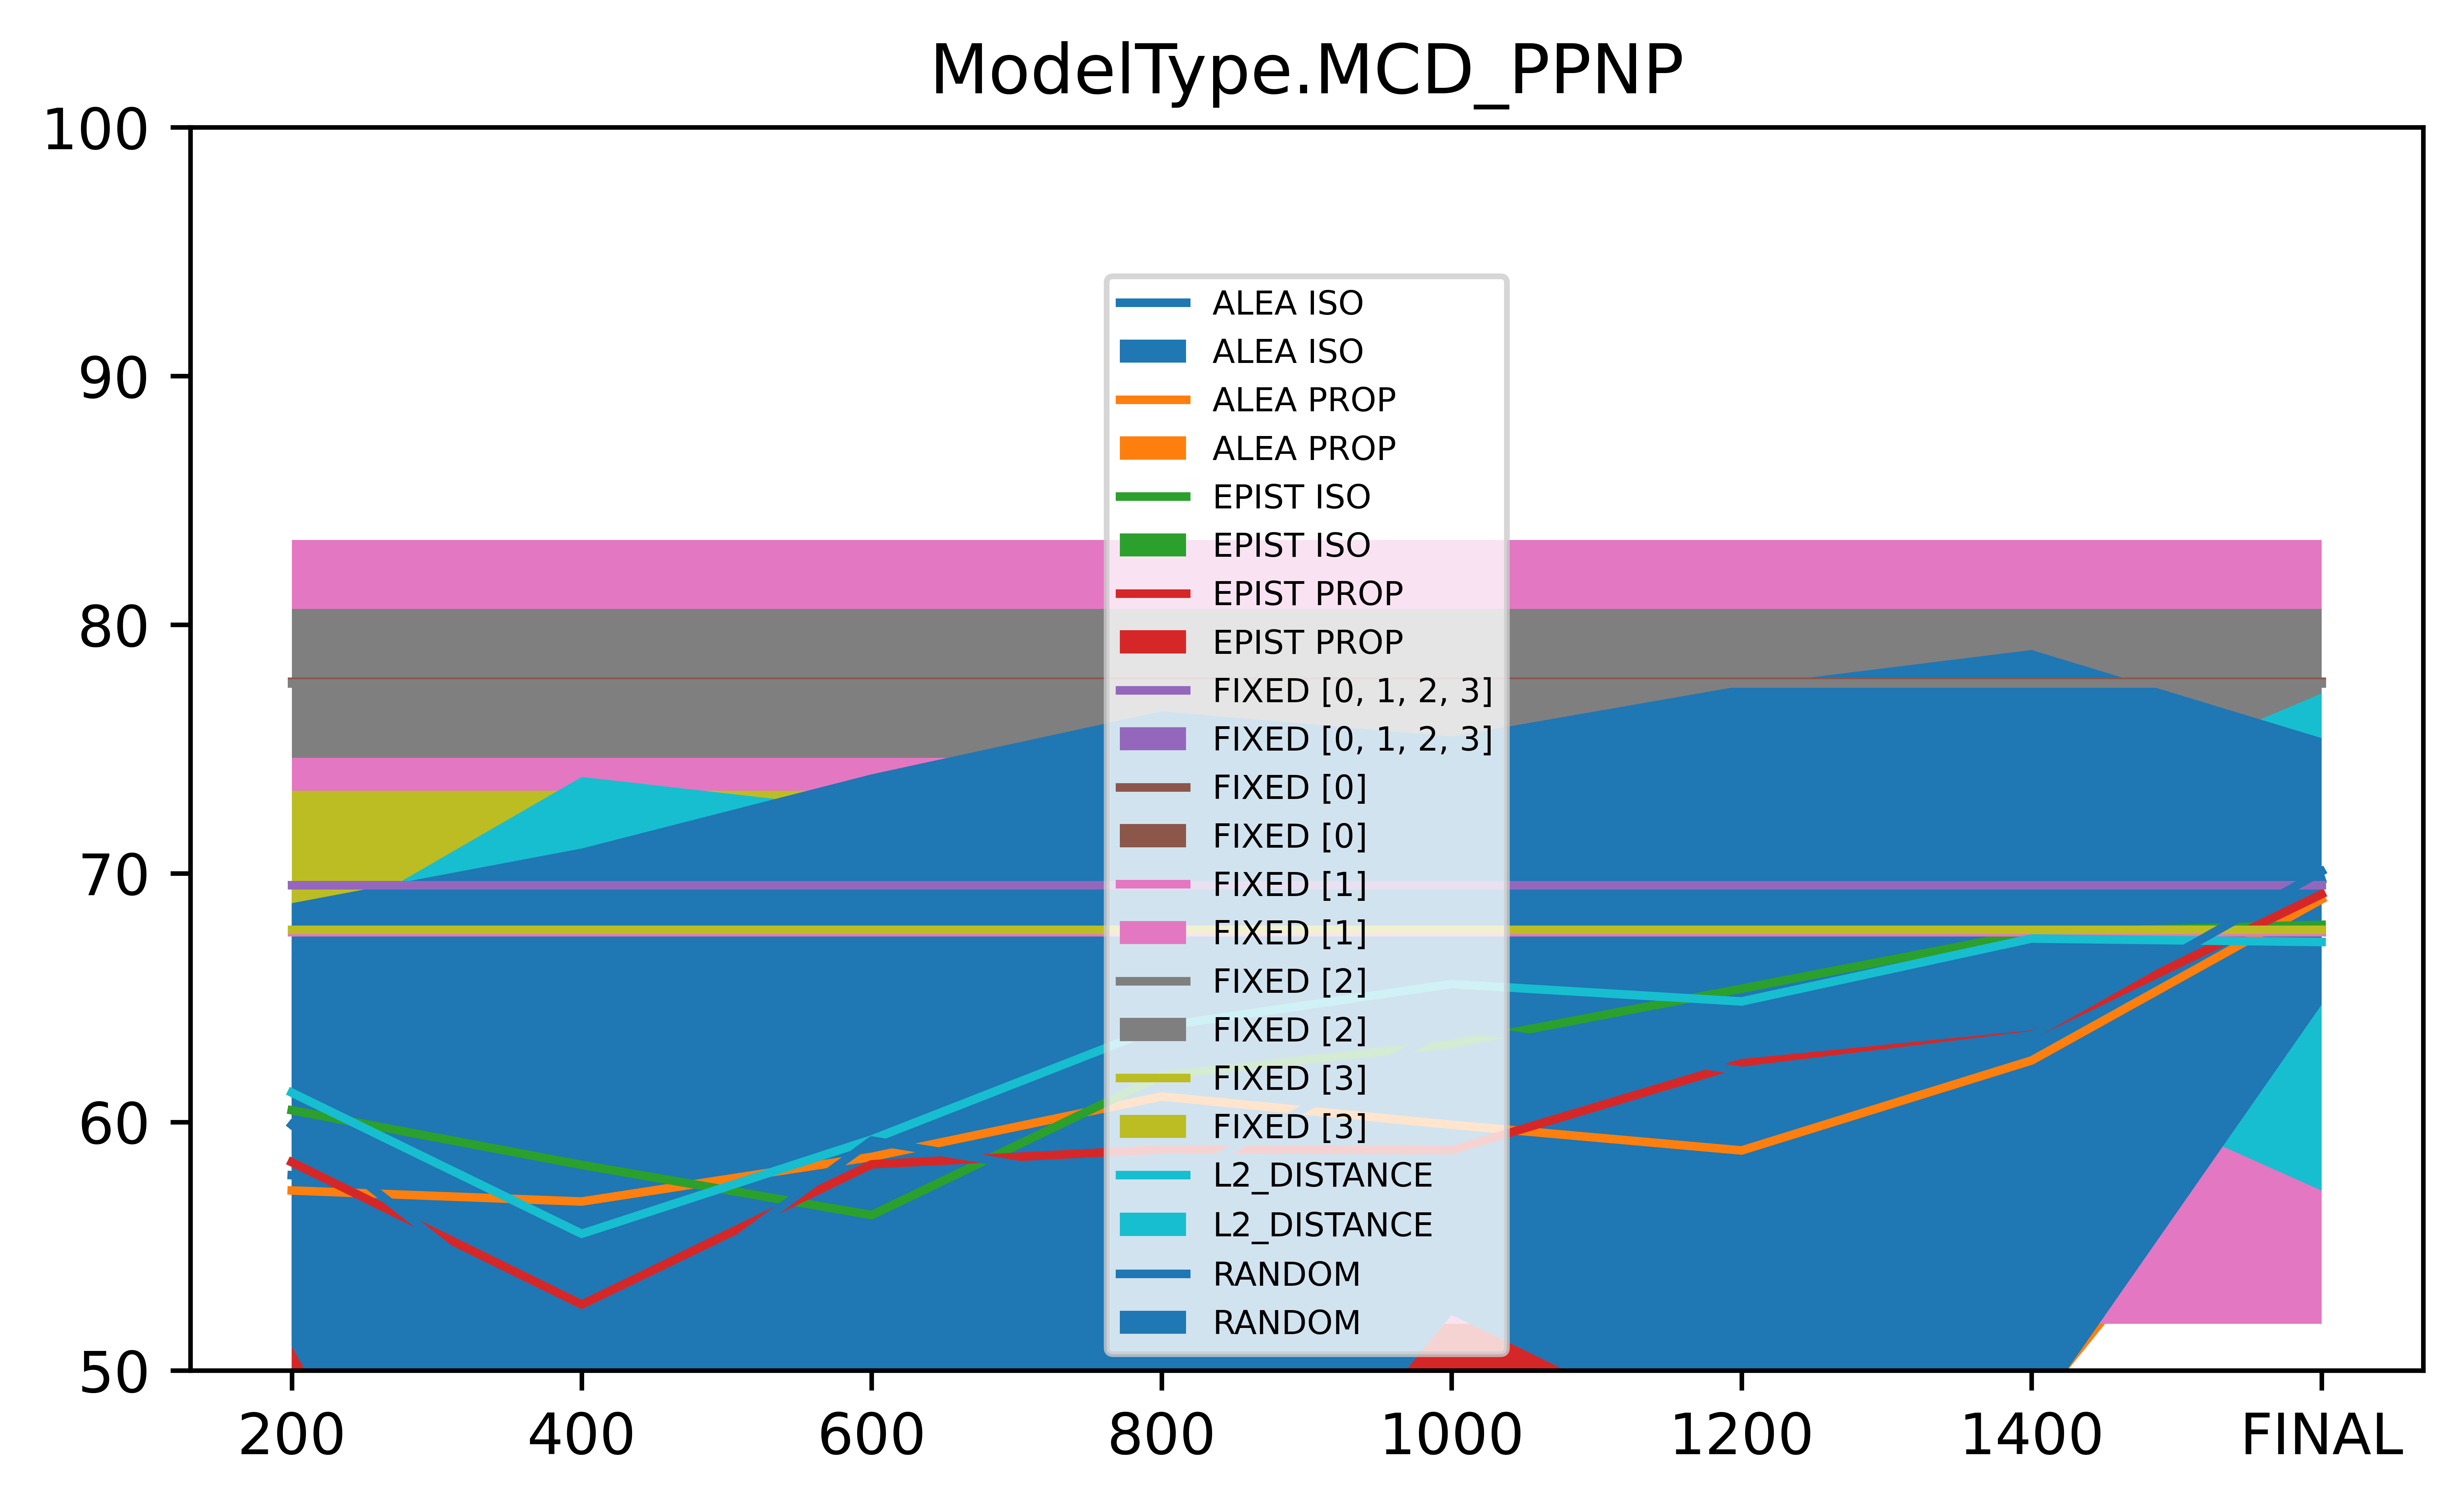

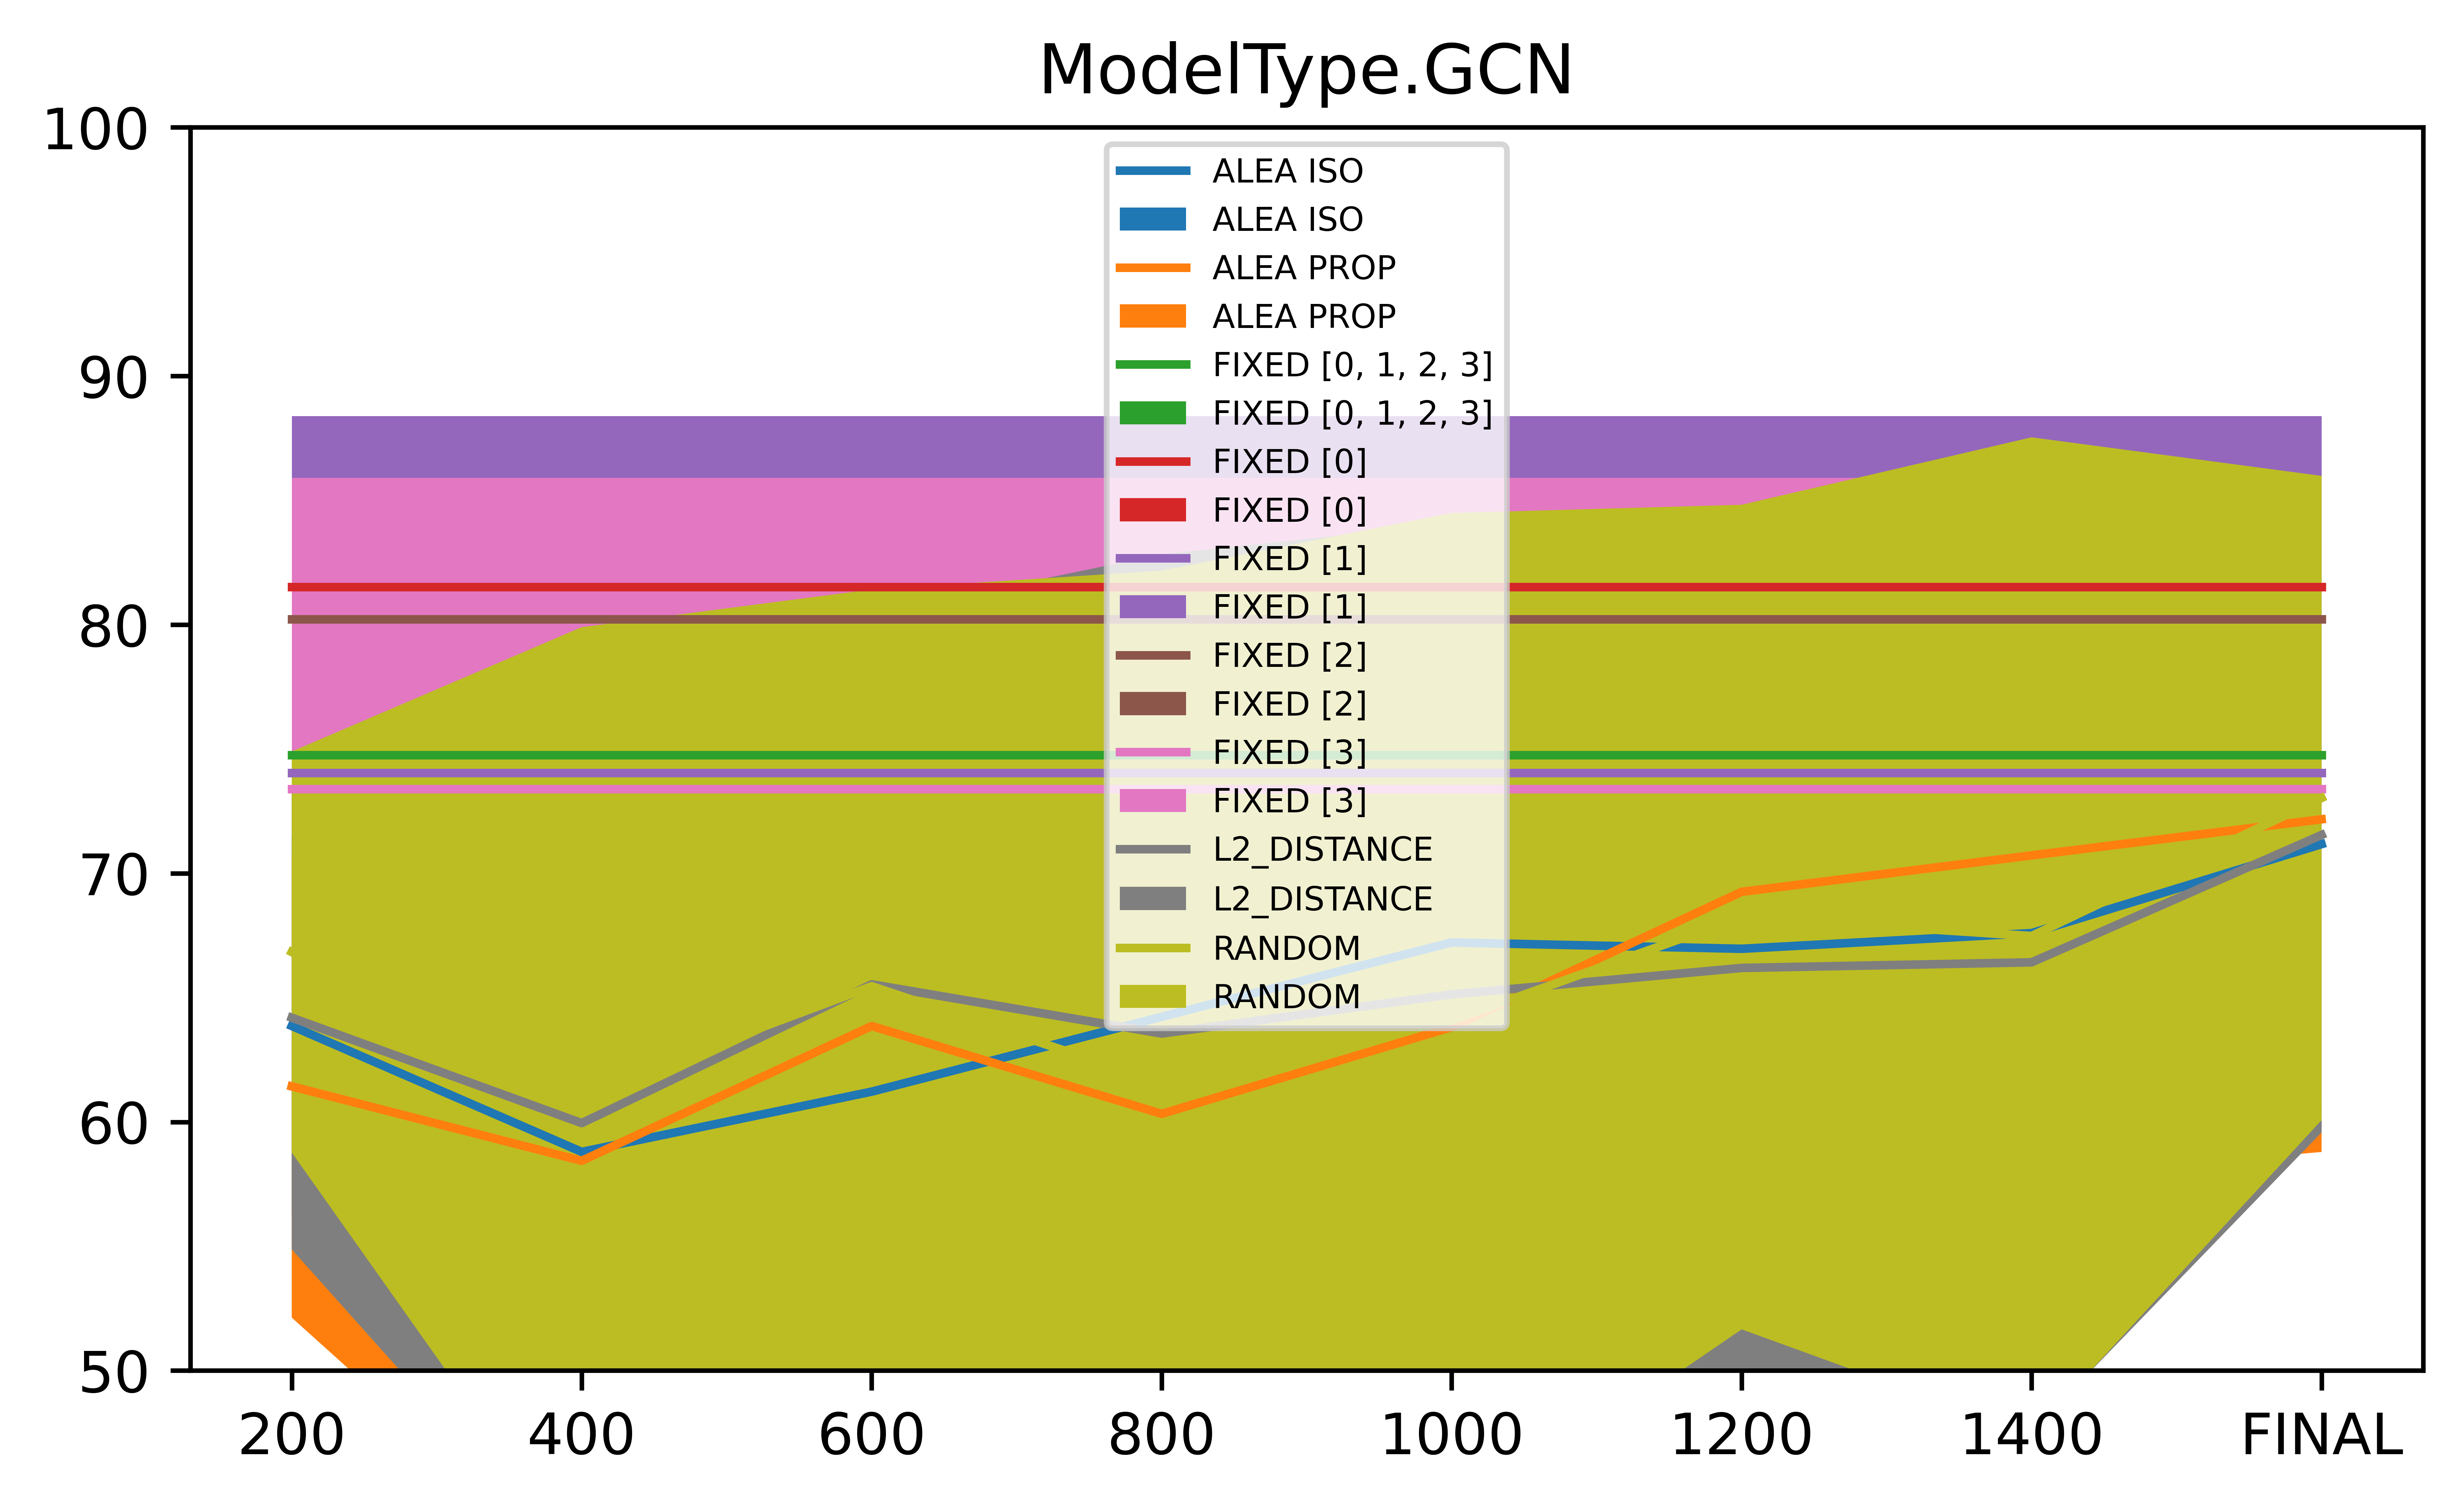

In [5]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

"""
https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
"""

def afterPoint(str):
    return str.split('.')[-1]

def getKey(str):
    if str == 'FINAL':
        return 99999999
    elif str == 'BASELINE':
        return 1
    else:
        return int(str)
    
def getKeyName(name):
    names = {
        'ALEA ISO': 4, 
        'ALEA PROP': 3, 
        'EPIST ISO': 2, 
        'EPIST PROP': 1, 
        'L2_DISTANCE': 5, 
        'RANDOM': 6, 
        'FIXED [0, 1, 2, 3]': 7,
        'FIXED [0]': 11,
        'FIXED [1]': 10,
        'FIXED [2]': 9,
        'FIXED [3]': 8
    }
    return names[name]
    
def sortBy(list, sorter, name):
    return [x for _, _, x in sorted(zip(sorter, name, list), key=lambda pair: getKey(pair[0]) * 1000 + getKeyName(pair[1]))]

def getSelectorName(run):
    active_learning_selector = afterPoint(run.config["experiment/active_learning_selector"])
    if active_learning_selector == "UNCERTAINTY":
        uncertainty_name = "ALEA" if afterPoint(run.config['experiment/active_learning_selector_uncertainty_mode']) == 'ALEATORIC' else 'EPIST'
        prop_name = 'ISO' if afterPoint(run.config['experiment/active_learning_selector_network_mode']) == 'ISOLATED' else 'PROP'
        active_learning_selector = f"{uncertainty_name} {prop_name}"
    elif active_learning_selector == "FIXED":
        prop_name = run.config['experiment/active_learning_training_type']
        active_learning_selector = f"{active_learning_selector} {prop_name}"
        
    return active_learning_selector

SUMMARY_FINAL_ACCURACY = '/eval/VALTEST/PROPAGATED/accuracy'
AL_PREFIX = 'mean/al/'
AL_SUFFIX = '/VALTEST/PROPAGATED/accuracy'

tag = "active_learning_sbmal_v6"

api = wandb.Api(timeout=200)
runs = api.runs("tum_daml_ba_antoniooroz/Guided Research", {"tags" : tag})

"""
COLOR FROM: https://www.learnui.design/tools/data-color-picker.html#divergent 21.02.2023
"""
COLOR_POSSIBILITIES = {
    'ALEA ISO': '#00876c', 
    'ALEA PROP': '#379469', 
    'EPIST ISO': '#58a066', 
    'EPIST PROP': '#78ab63', 
    'L2_DISTANCE': '#98b561', 
    'RANDOM': '#f95d6a', 
    'FIXED [0, 1, 2, 3]': '#b8bf62',
    'FIXED [0]': '#e09d4b',
    'FIXED [1]': '#e18745',
    'FIXED [2]': '#e06f45',
    'FIXED [3]': '#d43d51'
}

runs_per_model = {}

for run in runs:
    if run.config["debug"] or run.state != 'finished':
        continue
    
    model_type = str(run.config["model/type"])
    
    if model_type in runs_per_model:
        runs_per_model[model_type].append(run)
    else:
        runs_per_model[model_type] = [run]
        
for key, runs in runs_per_model.items():
    accuracies = []
    deviations = []
    timesteps = []
    selectors = []
    colors = []
    
    for run in runs:
        model = afterPoint(run.config["model/type"])
        
        #if run.config['experiment/active_learning_l2_distance_use_centroids']==True and afterPoint(run.config['experiment/active_learning_selector'])=='L2_DISTANCE':
        #    continue
    
        active_learning_selector = getSelectorName(run)

        if active_learning_selector.startswith('FIXED'):
            accuracies.append(run.summary[f"mean{SUMMARY_FINAL_ACCURACY}"]*100)
            deviations.append(run.summary[f"std{SUMMARY_FINAL_ACCURACY}"]*100)
            timesteps.append('200')
            selectors.append(active_learning_selector)
            colors.append(COLOR_POSSIBILITIES[active_learning_selector])
        else:
            for summary_key, summary_value in run.summary.items():
                if summary_key.startswith(AL_PREFIX) and summary_key.endswith(AL_SUFFIX):
                    num = summary_key.replace(AL_PREFIX, '').replace(AL_SUFFIX, '')
                    
                    if num == '1':
                        continue
                    
                    accuracies.append(summary_value*100)
                    deviations.append(run.summary[summary_key.replace('mean/', 'std/', 1)]*100)
                    timesteps.append(num)
                    selectors.append(active_learning_selector)
                    colors.append(COLOR_POSSIBILITIES[active_learning_selector])
                
        accuracies.append(run.summary[f"mean{SUMMARY_FINAL_ACCURACY}"]*100)
        deviations.append(run.summary[f"std{SUMMARY_FINAL_ACCURACY}"]*100)
        timesteps.append('FINAL')
        selectors.append(active_learning_selector)
        colors.append(COLOR_POSSIBILITIES[active_learning_selector])
        
    accuracies = sortBy(accuracies, timesteps, selectors)
    deviations = sortBy(deviations, timesteps, selectors)
    selectors = sortBy(selectors, timesteps, selectors)
    colors = sortBy(colors, timesteps, selectors)
    timesteps = sortBy(timesteps, timesteps, selectors)
        
    df = pd.DataFrame(dict(x=timesteps, y=accuracies, err=deviations, label=selectors, color=colors))
    groups = df.groupby('label')
    
    fig, ax = plt.subplots(figsize=(7, 4), dpi=1200)
    ax.margins(0.05)
    for name, group in groups:
        ax.set_ylim([0.0, 0.8])
        ax.plot(group.x, group.y, '-', label=name)
        ax.fill_between(group.x, group.y-group.err, group.y+group.err, label=name)
        ax.set_ylim(bottom=50, top=100)
        ax.yaxis.set_ticks(np.arange(50.0,105.0, 10))
    
    ax.legend(fontsize = 'xx-small')
    plt.title(key)
    plt.show()
